In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/COLAB/DL_3D_MIA_project/metrics_acdc.py /content

!pip install SimpleITK
!pip install nibabel
!pip install medpy
!pip install monai
import SimpleITK as sitk
import nibabel as nib
import monai

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from metrics_acdc import load_nii

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 11.4 MB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754463 sha256=8ccfe6f347edf3c7f058c4fbaecaf3fa525398d08c3ea4afd036193e431a699b
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 939 kB 13.7 MB/s 
The used device is cuda


Shape of image:  (216, 256, 10)
Affine transformation: 
 [[-1. -0.  0.  0.]
 [-0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Info of image: 
 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 216 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligne

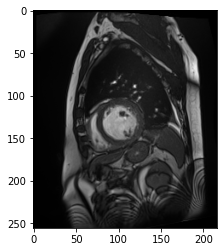

In [ ]:
# Load image from path using function load_nii
image_path = r'/content/drive/My Drive/COLAB/DL_3D_MIA_project/data/ACDC/training/patient001/patient001_frame12.nii.gz'
image = load_nii(image_path)

# Print shape and info of image, and affine transformation
print('Shape of image: ', image[0].shape)
print('Affine transformation: \n', image[1])
print('Info of image: \n', image[2])

# Plot middle slice of image
plt.figure()
plt.imshow(image[0][:,:,4].transpose(), cmap='gray')
plt.show()


# Construct the dictionary of file paths

In [ ]:
# split of dataset in train and val must be based on patients not on image slices
train_patient, validation_patient = train_test_split(range(1,101), train_size=0.8, random_state=42)
print(train_patient)
print(validation_patient)

def build_dict_acdc(data_path, mode='train'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train', 'val' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of images and masks.
    """
    # test if mode is correct
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    target = train_patient if mode == "train" else validation_patient 
    # make a corresponding list for all the mask files
    for patient_nb in target:
        # set patient_path
        patient_path = os.path.join(data_path, 'patient'+'{0:03}'.format(patient_nb))

        # extract ED and ES frame number from patient info
        patient_info = os.path.join(patient_path, 'Info.cfg')
        file = open(patient_info, 'r').readlines()
        ED_frame = int(file[0].split(':')[1])
        ES_frame = int(file[1].split(':')[1])

        # set image and mask paths
        image_path = []
        image_path.append(os.path.join(patient_path, 'patient'+'{0:03}'.format(patient_nb)+'_frame'+'{0:02}'.format(ED_frame)+'.nii.gz'))
        image_path.append(os.path.join(patient_path, 'patient'+'{0:03}'.format(patient_nb)+'_frame'+'{0:02}'.format(ES_frame)+'.nii.gz'))

        mask_path = []
        mask_path.append(os.path.join(patient_path, 'patient'+'{0:03}'.format(patient_nb)+'_frame'+'{0:02}'.format(ED_frame)+'_gt.nii.gz'))
        mask_path.append(os.path.join(patient_path, 'patient'+'{0:03}'.format(patient_nb)+'_frame'+'{0:02}'.format(ES_frame)+'_gt.nii.gz'))

        dicts.append({'img': image_path, 'mask': mask_path})
    return dicts


[56, 89, 27, 43, 70, 16, 41, 97, 10, 73, 12, 48, 86, 29, 94, 6, 67, 66, 36, 17, 50, 35, 8, 96, 28, 20, 82, 26, 63, 14, 25, 4, 18, 39, 9, 79, 7, 65, 37, 90, 57, 100, 55, 44, 51, 68, 47, 69, 62, 98, 80, 42, 59, 49, 99, 58, 76, 33, 95, 60, 64, 85, 38, 30, 2, 53, 22, 3, 24, 88, 92, 75, 87, 83, 21, 61, 72, 15, 93, 52]
[84, 54, 71, 46, 45, 40, 23, 81, 11, 1, 19, 31, 74, 34, 91, 5, 77, 78, 13, 32]


In [ ]:
# build dict of ACDC data
data_path = r'/content/drive/My Drive/COLAB/DL_3D_MIA_project/data/ACDC/training'
train_dict_list = build_dict_acdc(data_path, mode='train')
val_dict_list = build_dict_acdc(data_path, mode='val')


In [ ]:
# print size of train and val dataset in order to check whether the dataset is split properly
print(train_dict_list[0])
print('Size of train dataset: ', len(train_dict_list))
print('Size of val dataset: ', len(val_dict_list))

{'img': ['/content/drive/My Drive/COLAB/DL_3D_MIA_project/data/ACDC/training/patient056/patient056_frame01.nii.gz', '/content/drive/My Drive/COLAB/DL_3D_MIA_project/data/ACDC/training/patient056/patient056_frame12.nii.gz'], 'mask': ['/content/drive/My Drive/COLAB/DL_3D_MIA_project/data/ACDC/training/patient056/patient056_frame01_gt.nii.gz', '/content/drive/My Drive/COLAB/DL_3D_MIA_project/data/ACDC/training/patient056/patient056_frame12_gt.nii.gz']}
Size of train dataset:  80
Size of val dataset:  20


# Define a function that loads the ACDC dataset

In [ ]:
class LoadACDCData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the acdc segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image_ED = load_nii(sample['img'][0])
        image = image_ED[0][:,:,4]
        # image_ES = load_nii(sample['img'][1])
        # image.append(image_ES[0])
        _, image_ED_aff, image_ED_header = load_nii(sample['img'][0])
        # remove third row and column to get affine matrix corresponding to 2D image
        image_ED_aff = np.delete(image_ED_aff, 2, 0)
        image_ED_aff = np.delete(image_ED_aff, 2, 1)
        # set pixel dimensions in image_ED_aff
        image_ED_aff[0,0] = -image_ED_header['pixdim'][1]
        image_ED_aff[1,1] = -image_ED_header['pixdim'][2]

        mask_ED = load_nii(sample['mask'][0])
        mask = mask_ED[0][:,:,4]
        discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)
        mask = discrete_transform(mask)
        # mask_ES = load_nii(sample['mask'][1])
        # mask.append(mask_ES[0])
        _, mask_ED_aff, mask_ED_header = load_nii(sample['mask'][0])
        # remove third row and column to get affine matrix corresponding to 2D image
        mask_ED_aff = np.delete(mask_ED_aff, 2, 0)
        mask_ED_aff = np.delete(mask_ED_aff, 2, 1)
        # set pixel dimensions in image_ED_aff
        mask_ED_aff[0,0] = -mask_ED_header['pixdim'][1]
        mask_ED_aff[1,1] = -mask_ED_header['pixdim'][2]

        return {'img': image, 'mask': mask, 'img_meta_dict': {'affine': image_ED_aff, 'pixdim': image_ED_header['pixdim']},
                'mask_meta_dict': {'affine': mask_ED_aff, 'pixdim': mask_ED_header['pixdim']}}

In [ ]:
# create dataset with cache mechanism that can load data and cache deterministic transforms’ result during training
train_dataset = monai.data.CacheDataset(train_dict_list, transform=LoadACDCData())
val_dataset =monai.data.CacheDataset(val_dict_list, transform=LoadACDCData())


Loading dataset:   0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/monai/transforms/post/array.py:181: UserWarning: `threshold_values=True/False` is deprecated, please use `threshold=value` instead.
  warnings.warn("`threshold_values=True/False` is deprecated, please use `threshold=value` instead.")
Loading dataset: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


# Visualize ACDC sample in train_dataset

Size of train_dataset:  80
Size of val dataset:  20
Size of image:  (216, 256)
affine: 
 [[-1.36719 -0.       0.     ]
 [-0.      -1.36719  0.     ]
 [ 0.       0.       1.     ]]
pixdim:  [ 1.       1.36719  1.36719 10.       1.       1.       1.       1.     ]


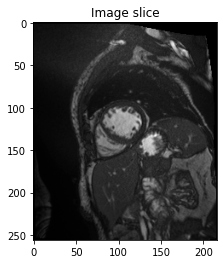

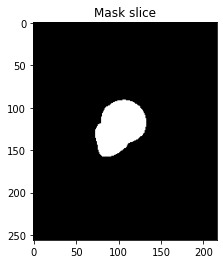

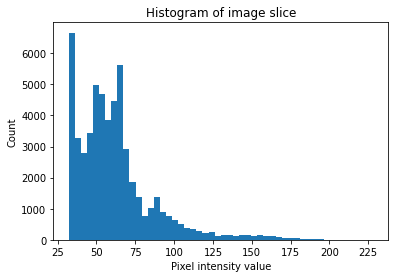

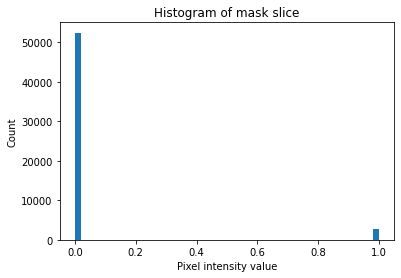

In [ ]:
# print size of train and val dataset
print('Size of train_dataset: ', len(train_dataset))
print('Size of val dataset: ', len(val_dataset))

# print size of image, affine transformation and pixdim of first patient in train_dataset
selected_patient = train_dataset[0]
print('Size of image: ', selected_patient['img'].shape)
print('affine: \n', selected_patient['img_meta_dict']['affine'])
print('pixdim: ', selected_patient['img_meta_dict']['pixdim'])

# plot image slice
plt.figure()
plt.imshow(selected_patient['img'].transpose(), cmap='gray')
plt.title('Image slice')
plt.show()

# plot mask slice
plt.figure()
plt.imshow(selected_patient['mask'].transpose(), cmap='gray')
plt.title('Mask slice')
plt.show()

# plot histogram of image slice
plt.figure()
plt.hist(selected_patient['img'].flatten(), bins=50)
plt.title('Histogram of image slice')
plt.xlabel('Pixel intensity value')
plt.ylabel('Count')
plt.show()

# plot histogram of image slice
plt.figure()
plt.hist(selected_patient['mask'].flatten(), bins=50)
plt.title('Histogram of mask slice')
plt.xlabel('Pixel intensity value')
plt.ylabel('Count')
plt.show()

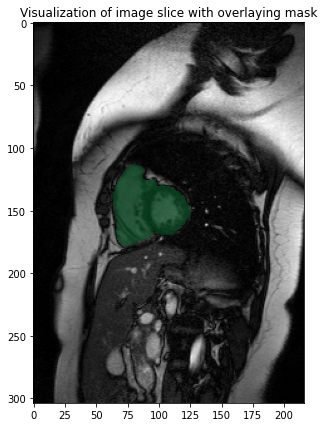

In [ ]:
def visualize_acdc_sample(sample, frame=0, mask_value=1, title=None):
    # Visualize the x-ray and overlay the mask, using the dictionary as input
    image = np.squeeze(sample['img']) # include frame
    mask = np.squeeze(sample['mask']) # include frame

    plt.figure(figsize=[10,7])
    plt.imshow(image.transpose(), 'gray')

    overlay_mask = np.ma.masked_where(mask == 0, mask == mask_value)
    plt.imshow(overlay_mask.transpose(), 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')

    if title is not None:
        plt.title(title)
    plt.show()

visualize_acdc_sample(train_dataset[41], frame=0, mask_value=1, title='Visualization of image slice with overlaying mask')

# Define the transforms that should be applied on the train data

In [ ]:
train_transform = monai.transforms.Compose(
    [
        LoadACDCData(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityRangePercentilesd(keys=['img'], lower=5, upper=95, b_min=0, b_max=1),
        monai.transforms.Spacingd(keys=['img', 'mask'], 
                                  pixdim=(1.5, 1.5), 
                                  mode=("bilinear", "nearest")),
        monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=[128,128], random_size=False)
    ]
)


# Construct the CacheDataset using the dictionary and transform

In [ ]:
train_dataset_transformed = monai.data.CacheDataset(train_dict_list, transform=train_transform)
#Use same transform for validation set
val_dataset_transformed = monai.data.CacheDataset(val_dict_list, transform=train_transform)


Loading dataset:   0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/monai/transforms/post/array.py:181: UserWarning: `threshold_values=True/False` is deprecated, please use `threshold=value` instead.
  warnings.warn("`threshold_values=True/False` is deprecated, please use `threshold=value` instead.")
Loading dataset: 100%|██████████| 20/20 [00:01<00:00, 14.06it/s]


Size of train dataset:  80
Size of image:  (216, 256)
Max intensity value of image:  228.0
Size of mask:  (216, 256)
affine: 
 [[-1.36719 -0.       0.     ]
 [-0.      -1.36719  0.     ]
 [ 0.       0.       1.     ]]
pixdim: 
 [ 1.       1.36719  1.36719 10.       1.       1.       1.       1.     ]
Size of transformed train dataset:  80
Size of image:  (1, 128, 128)
Max intensity value of image:  2.3061738
Size of mask:  (1, 128, 128)
affine: 
 [[-1.5  0.   0. ]
 [ 0.  -1.5  0. ]
 [ 0.   0.   1. ]]
pixdim: 
 [ 1.       1.36719  1.36719 10.       1.       1.       1.       1.     ]


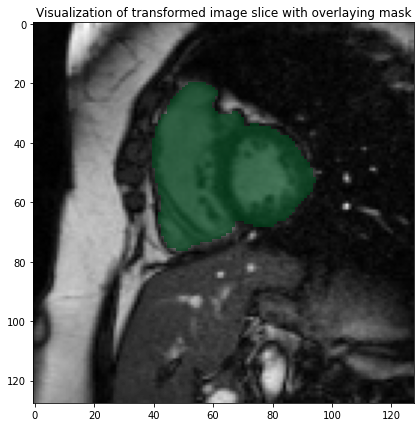

In [ ]:
print('Size of train dataset: ', len(train_dataset))
print('Size of image: ', train_dataset[0]['img'].shape)
print('Max intensity value of image: ', np.max(train_dataset[0]['img']))
print('Size of mask: ', train_dataset[0]['mask'].shape)
print('affine: \n', train_dataset[0]['img_meta_dict']['affine'])
print('pixdim: \n', train_dataset[0]['img_meta_dict']['pixdim'])

print('Size of transformed train dataset: ', len(train_dataset_transformed))
print('Size of image: ', train_dataset_transformed[0]['img'].shape)
print('Max intensity value of image: ', np.max(train_dataset_transformed[0]['img']))
print('Size of mask: ', train_dataset_transformed[0]['mask'].shape)
print('affine: \n', train_dataset_transformed[0]['img_meta_dict']['affine'])
print('pixdim: \n', train_dataset_transformed[0]['img_meta_dict']['pixdim'])

visualize_acdc_sample(train_dataset_transformed[41], frame=0, mask_value=1, title='Visualization of transformed image slice with overlaying mask')


In [ ]:
i=0
for sample in train_dataset_transformed:
    i=i+1
    image = sample["img"]
    mask = sample["mask"]
    pixdim = sample["img_meta_dict"]['pixdim']
    print(i, ": Image size", image.shape, "Mask size" , mask.shape
          # , "Pixel Dimensions", pixdim
          )

1 : Image size (1, 128, 128) Mask size (1, 128, 128)
2 : Image size (1, 128, 128) Mask size (1, 128, 128)
3 : Image size (1, 128, 128) Mask size (1, 128, 128)
4 : Image size (1, 128, 128) Mask size (1, 128, 128)
5 : Image size (1, 128, 128) Mask size (1, 128, 128)
6 : Image size (1, 128, 128) Mask size (1, 128, 128)
7 : Image size (1, 128, 128) Mask size (1, 128, 128)
8 : Image size (1, 128, 128) Mask size (1, 128, 128)
9 : Image size (1, 128, 128) Mask size (1, 128, 128)
10 : Image size (1, 128, 128) Mask size (1, 128, 128)
11 : Image size (1, 128, 128) Mask size (1, 128, 128)
12 : Image size (1, 128, 128) Mask size (1, 128, 128)
13 : Image size (1, 128, 128) Mask size (1, 128, 128)
14 : Image size (1, 128, 128) Mask size (1, 128, 128)
15 : Image size (1, 128, 128) Mask size (1, 128, 128)
16 : Image size (1, 128, 128) Mask size (1, 128, 128)
17 : Image size (1, 128, 128) Mask size (1, 128, 128)
18 : Image size (1, 128, 128) Mask size (1, 128, 128)
19 : Image size (1, 128, 128) Mask si

# Build a train dataloader from the CacheDataset

In [ ]:
train_dataloader = monai.data.DataLoader(train_dataset_transformed, batch_size=16, shuffle=True)
val_dataloader = monai.data.DataLoader(val_dataset_transformed, batch_size=16, shuffle=True)
print('train_dataloader: ', len(train_dataloader))
print('val_dataloader: ', len(val_dataloader))


train_dataloader:  5
val_dataloader:  2


# Setting up the neural network, loss function, and optimizer

In [ ]:
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels = (16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: ', num_params)

#Sigmoid because we only care to distinguish between background and heart
loss_function = monai.losses.TverskyLoss(sigmoid=True, alpha=0.5, beta=0.5, batch=True)

print('loss_function: ', loss_function)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print('optimizer:\n', optimizer)


Number of parameters:  1624844
loss_function:  TverskyLoss()
optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [ ]:
import tqdm

def train_acdc(model, train_dataloader, val_dataloader, optimizer, epochs, val_freq=1):
    training_loss = []
    validation_loss = []

    for epoch in range(epochs):
        model.train()    
        epoch_loss = 0
        step = 0
        for batch_data in train_dataloader: 
            step += 1
            optimizer.zero_grad()
            outputs = model(batch_data['img'].float().to(device))
            # FILL IN
            loss = loss_function(outputs, batch_data['mask'].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        training_loss.append(epoch_loss/step)
        # validation part
        step = 0
        val_loss = 0
        for batch_data in val_dataloader:
            step += 1
            model.eval()
            outputs = model(batch_data['img'].float().to(device))
            # FILL IN
            loss = loss_function(outputs, batch_data['mask'].to(device))
            val_loss += loss.item()
        validation_loss.append(val_loss/step)
        print('epoch:', epoch+1, ' training loss:', training_loss[-1], ' validation loss:', validation_loss[-1])

   

    return model, training_loss, validation_loss


300 epochs was deemed to be the best amount of epochs for training the pre-processing model

In [ ]:
val_freq = 10
n_epochs = 300
model, train_loss, val_loss = train_acdc(model, train_dataloader, val_dataloader, optimizer, epochs=n_epochs, val_freq=val_freq)

epoch: 1  training loss: 0.7803630352020263  validation loss: 0.7698280513286591
epoch: 2  training loss: 0.7476885437965393  validation loss: 0.7496605813503265
epoch: 3  training loss: 0.7274673581123352  validation loss: 0.7041196227073669
epoch: 4  training loss: 0.7286606073379517  validation loss: 0.675658106803894
epoch: 5  training loss: 0.713170862197876  validation loss: 0.704889327287674
epoch: 6  training loss: 0.7246366500854492  validation loss: 0.6837410628795624
epoch: 7  training loss: 0.698362386226654  validation loss: 0.6883766949176788
epoch: 8  training loss: 0.6968611001968383  validation loss: 0.6809164881706238
epoch: 9  training loss: 0.6855372667312623  validation loss: 0.6602813601493835
epoch: 10  training loss: 0.6873498558998108  validation loss: 0.6661364734172821
epoch: 11  training loss: 0.6873866200447083  validation loss: 0.6353962123394012
epoch: 12  training loss: 0.6782825827598572  validation loss: 0.6632970571517944
epoch: 13  training loss: 0.6

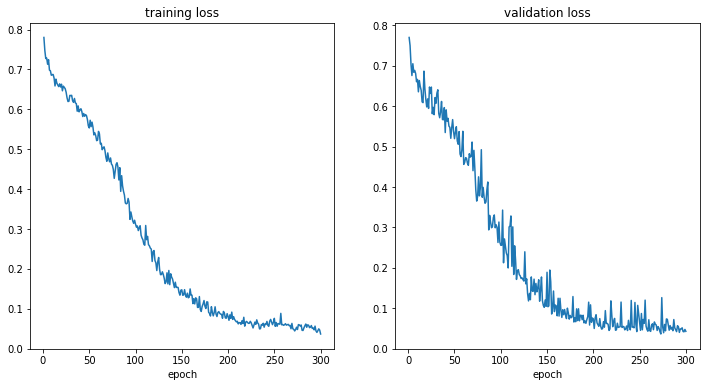

In [ ]:
# plot training and validation loss
plt.figure('', (12, 6))

plt.subplot(1, 2, 1)
plt.title("training loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("validation loss")
val_interval=1
x = [val_interval * (i + 1) for i in range(len(val_loss))]
y = val_loss
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
os.chdir('/content/drive/My Drive/COLAB/DL_3D_MIA_project/models') 

# uncomment to store the network parameters  
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%Y%m%d_%H%M_")+'model_preprocess.pt'
# torch.save(model.state_dict(), filename)

# Load the network parameters
PATH = r'20220615_1137_model_preprocess.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Visual evaluation of trained network
This section shows the visualization of the predicted mask by the ROI-Extracting UNet as well as the center of mass coordinate calculated by the model.

These coordinates are saved in the drive to be used in the training notebooks.

In [ ]:
import skimage
import scipy

def getLargestCC(output):
    labels = skimage.measure.label(output)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def visual_evaluation(sample, model):
    """
    Allow the visual inspection the result of one sample by plotting 
    the X-ray image, the ground truth (green) and the segmentation map produced by the network (red).
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an X-ray ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[128,128], overlap=0.25, mode='gaussian')
    discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)
    Sigmoid = torch.nn.Sigmoid()
    with torch.no_grad():
        output = Sigmoid(inferer(sample['img'].to(device), network=model).cpu()).squeeze()
        output = discrete_transform(output)
        print(np.unique(output))
    
    output = getLargestCC(output)
    output = output.astype(int)
    center_coordinates = scipy.ndimage.measurements.center_of_mass(output)
    center_coordinates = np.round(center_coordinates)   # round center_coordinates to get int values
    print('center: ', center_coordinates)

    plt.figure()
    plt.imshow(output)
    plt.scatter(center_coordinates[1], center_coordinates[0], color='r')
    plt.show()
    
    fig, ax = plt.subplots(1,2, figsize = [12, 10])
    
    # Plot X-ray image
    ax[0].imshow(sample["img"].squeeze(), 'gray')
    # Plot ground truth
    mask = np.squeeze(sample['mask'])
    overlay_mask = np.ma.masked_where(mask == 0, mask == 1)
    ax[0].imshow(overlay_mask, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[0].set_title('Ground truth')
    # Plot output
    overlay_output = np.ma.masked_where(output < 0.1, output >0.99)
    ax[1].imshow(sample['img'].squeeze(), 'gray')
    ax[1].imshow(overlay_output, 'Greens', alpha = 0.7, clim=[0,1])
    ax[1].set_title('Prediction')
    plt.show()

    return output, center_coordinates, mask

In [ ]:
val_dict_list_evaluation = build_dict_acdc(data_path, mode='val')
val_transform_evalation = monai.transforms.Compose([
        LoadACDCData(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityRangePercentilesd(keys=['img'], lower=5, upper=95, b_min=0, b_max=1),
        monai.transforms.Spacingd(keys=['img', 'mask'], 
                                  pixdim=(1.5,1.5), 
                                  mode=['bilinear', 'nearest']),
    ]
)
val_dataset_evaluation = monai.data.CacheDataset(val_dict_list_evaluation, transform=val_transform_evalation)
val_dataloader_evaluation = monai.data.DataLoader(val_dataset_evaluation, batch_size=1)

# folder in which predictions should be saved
os.chdir('/content/drive/My Drive/COLAB/DL_3D_MIA_project/predictions/preprocessing')

output_val = []
center_coordinates_val = []
mask_val = []
for i, sample in enumerate(val_dataloader_evaluation):
    print('patient number: ', validation_patient[i])
    output_sample, center_sample, mask_sample = visual_evaluation(sample, model)
    output_val.append(output_sample)
    center_coordinates_val.append(center_sample)
    mask_val.append(mask_sample)
    np.save('predicted_segmentation_patient'+str(validation_patient[i])+'.npy', output_sample)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# save prediction to google drive
os.chdir('/content/drive/MyDrive/COLAB/DL_3D_MIA_project/predictions/preprocessing')
np.save('predicted_segmentation_patient'+str(validation_patient[0])+'.npy', output_sample)


In [ ]:
print('Length of validation center coordinates: ', len(center_coordinates_val))
print('Center coordinates of first sample in validation dataset: ', center_coordinates_val[0])
for i in range(len(center_coordinates_val)):
  print('[', center_coordinates_val[i][0], ' ,', center_coordinates_val[i][1], '],')


Length of validation center coordinates:  20
Center coordinates of first sample in validation dataset:  [ 92. 100.]
[ 92.0  , 100.0 ],
[ 85.0  , 143.0 ],
[ 81.0  , 121.0 ],
[ 100.0  , 62.0 ],
[ 90.0  , 132.0 ],
[ 100.0  , 129.0 ],
[ 93.0  , 125.0 ],
[ 73.0  , 134.0 ],
[ 77.0  , 112.0 ],
[ 102.0  , 139.0 ],
[ 90.0  , 131.0 ],
[ 99.0  , 126.0 ],
[ 122.0  , 129.0 ],
[ 105.0  , 131.0 ],
[ 89.0  , 111.0 ],
[ 115.0  , 95.0 ],
[ 91.0  , 133.0 ],
[ 71.0  , 120.0 ],
[ 99.0  , 124.0 ],
[ 115.0  , 138.0 ],


In [ ]:
# SAME FOR TRAINING DATASET

train_dict_list_evaluation = build_dict_acdc(data_path, mode='train')
train_transform_evalation = monai.transforms.Compose([
        LoadACDCData(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityRangePercentilesd(keys=['img'], lower=5, upper=95, b_min=0, b_max=1),
        monai.transforms.Spacingd(keys=['img', 'mask'], 
                                  pixdim=(1.5,1.5), 
                                  mode=['bilinear', 'nearest']),
    ]
)
train_dataset_evaluation = monai.data.CacheDataset(train_dict_list_evaluation, transform=train_transform_evalation)
train_dataloader_evaluation = monai.data.DataLoader(train_dataset_evaluation, batch_size=1)

# folder in which predictions should be saved
os.chdir('/content/drive/My Drive/COLAB/DL_3D_MIA_project/predictions/preprocessing')

output_train = []
center_coordinates_train = []
mask_train = []
for i, sample in enumerate(train_dataloader_evaluation):
    output_sample, center_sample, mask_sample = visual_evaluation(sample, model)
    output_train.append(output_sample)
    center_coordinates_train.append(center_sample)
    mask_train.append(mask_sample)
    np.save('predicted_segmentation_patient'+str(train_patient[i])+'.npy', output_sample)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print('Length of train center coordinates: ', len(center_coordinates_train))
print('Center coordinates of first sample in training dataset: ', center_coordinates_train[0])
for i in range(len(center_coordinates_train)):
  print('[', center_coordinates_train[i][0], ' ,', center_coordinates_train[i][1], '],')

Length of train center coordinates:  80
Center coordinates of first sample in training dataset:  [ 92. 112.]
[ 92.0  , 112.0 ],
[ 122.0  , 128.0 ],
[ 79.0  , 128.0 ],
[ 89.0  , 139.0 ],
[ 86.0  , 126.0 ],
[ 83.0  , 126.0 ],
[ 84.0  , 137.0 ],
[ 102.0  , 144.0 ],
[ 104.0  , 134.0 ],
[ 94.0  , 135.0 ],
[ 86.0  , 137.0 ],
[ 108.0  , 127.0 ],
[ 85.0  , 135.0 ],
[ 71.0  , 139.0 ],
[ 118.0  , 93.0 ],
[ 116.0  , 145.0 ],
[ 115.0  , 92.0 ],
[ 89.0  , 118.0 ],
[ 94.0  , 128.0 ],
[ 109.0  , 150.0 ],
[ 84.0  , 135.0 ],
[ 98.0  , 144.0 ],
[ 92.0  , 133.0 ],
[ 82.0  , 125.0 ],
[ 80.0  , 153.0 ],
[ 116.0  , 147.0 ],
[ 120.0  , 68.0 ],
[ 87.0  , 133.0 ],
[ 111.0  , 76.0 ],
[ 98.0  , 78.0 ],
[ 106.0  , 110.0 ],
[ 110.0  , 86.0 ],
[ 99.0  , 123.0 ],
[ 94.0  , 144.0 ],
[ 84.0  , 126.0 ],
[ 69.0  , 151.0 ],
[ 124.0  , 140.0 ],
[ 112.0  , 113.0 ],
[ 128.0  , 160.0 ],
[ 75.0  , 137.0 ],
[ 88.0  , 122.0 ],
[ 80.0  , 130.0 ],
[ 116.0  , 90.0 ],
[ 111.0  , 98.0 ],
[ 112.0  , 143.0 ],
[ 137.0  , 99.0 ],
[ 170.

# Compute evaluation metrics
In this section we compute the metrics of our ROI-Extracting model

In [ ]:
print(output_val[0].shape)
print(mask_val[0].shape)

metric_dice = monai.metrics.compute_meandice
metric_hausdorff = monai.metrics.compute_hausdorff_distance

dice_val = []
hausdorff_val = []
for i in range(len(validation_patient)):
  output_shape = output_val[i].shape
  output = torch.Tensor(np.zeros([1,1,output_shape[0],output_shape[1]]))
  output[0,0,:,:] = torch.Tensor(output_val[i])
  mask = torch.Tensor(np.zeros([1,1,output_shape[0],output_shape[1]]))
  mask[0,0,:,:] = mask_val[i]

  dice_i = metric_dice(output, mask)
  dice_val.append(dice_i)
  hausdorff_i = metric_hausdorff(output, mask)
  hausdorff_val.append(hausdorff_i)

print(dice_val)
print(hausdorff_val)

print(output_val[0].shape)
print(mask_val[0].shape)

# SAME FOR TRAINING DATASET
dice_train = []
hausdorff_train = []
for i in range(len(train_patient)):
  output_shape = output_train[i].shape
  output = torch.Tensor(np.zeros([1,1,output_shape[0],output_shape[1]]))
  output[0,0,:,:] = torch.Tensor(output_train[i])
  mask = torch.Tensor(np.zeros([1,1,output_shape[0],output_shape[1]]))
  mask[0,0,:,:] = mask_train[i]

  dice_i = metric_dice(output, mask)
  dice_train.append(dice_i)
  hausdorff_i = metric_hausdorff(output, mask)
  hausdorff_train.append(hausdorff_i)

print(dice_train)
print(hausdorff_train)


(190, 233)
torch.Size([190, 233])
[tensor([[0.9377]]), tensor([[0.8291]]), tensor([[0.9386]]), tensor([[0.9686]]), tensor([[0.9703]]), tensor([[0.9609]]), tensor([[0.9718]]), tensor([[0.9546]]), tensor([[0.9729]]), tensor([[0.9718]]), tensor([[0.9797]]), tensor([[0.9726]]), tensor([[0.9792]]), tensor([[0.9731]]), tensor([[0.9669]]), tensor([[0.9460]]), tensor([[0.9713]]), tensor([[0.9783]]), tensor([[0.9612]]), tensor([[0.9672]])]
[tensor([[5.]], dtype=torch.float64), tensor([[18.6011]], dtype=torch.float64), tensor([[7.2801]], dtype=torch.float64), tensor([[2.8284]], dtype=torch.float64), tensor([[3.]], dtype=torch.float64), tensor([[4.]], dtype=torch.float64), tensor([[3.]], dtype=torch.float64), tensor([[6.3246]], dtype=torch.float64), tensor([[3.]], dtype=torch.float64), tensor([[4.4721]], dtype=torch.float64), tensor([[2.]], dtype=torch.float64), tensor([[2.8284]], dtype=torch.float64), tensor([[2.2361]], dtype=torch.float64), tensor([[3.]], dtype=torch.float64), tensor([[3.6056]]

In [ ]:
# compute mean dice and hausdorff
dice_cumulative=0
hausdorff_cumulative=0

for i in range(len(validation_patient)):
  dice_cumulative = dice_cumulative+dice_val[i][0][0]
  hausdorff_cumulative = hausdorff_cumulative+hausdorff_val[i][0][0]

dice_val_mean = dice_cumulative/len(dice_val)
hausdorff_val_mean = hausdorff_cumulative/len(hausdorff_val)

print('Dice coefficient for validation dataset: ', dice_val_mean.numpy())
print('Hausdorff for validation dataset: ', hausdorff_val_mean.numpy())

# SAME FOR TRAINING DATASET
dice_cumulative=0
hausdorff_cumulative=0

for i in range(len(train_patient)):
  dice_cumulative = dice_cumulative+dice_train[i][0][0]
  hausdorff_cumulative = hausdorff_cumulative+hausdorff_train[i][0][0]

dice_train_mean = dice_cumulative/len(dice_train)
hausdorff_train_mean = hausdorff_cumulative/len(hausdorff_train)

print('Dice coefficient for training dataset: ', dice_train_mean.numpy())
print('Hausdorff for training dataset: ', hausdorff_train_mean.numpy())

Dice coefficient for validation dataset:  0.9585866
Hausdorff for validation dataset:  4.704760543026003
Dice coefficient for training dataset:  0.9592253
Hausdorff for training dataset:  5.246722621095389
